# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

print('ok')

ok


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape, feat_info.shape)

# Checking azdias
azdias.head(10)

(891221, 85) (85, 4)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   
5                  3              1                 5               2   
6                  1              5                 1               5   
7                  3              3                 4               1   
8                  4              4                 2               4   
9                  2              4                 2               3   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   
5                      2                 5    ...            2.0         3.0   
6                      4                 3    ...            3.0         3.0   
7                      3                 2    ...            3.0         3.0   
8                      2                 2    ...            2.0         3.0   
9                      5                 4    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   
5         1.0         1.0          1.0       5.0       5.0     2.0   
6         1.0         0.0          1.0       5.0       5.0     4.0   
7         1.0         0.0          1.0       4.0       4.0     2.0   
8         2.0         1.0          1.0       3.0       3.0     2.0   
9         2.0         1.0          1.0       3.0       3.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  
5          3.0       3.0  
6          6.0       3.0  
7          5.0       2.0  
8          4.0       3.0  
9          3.0       1.0  

[10 rows x 85 columns]

In [4]:
# Checking feat_info
feat_info.head(10)

attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
5          FINANZ_SPARER            person      ordinal               [-1]
6       FINANZ_VORSORGER            person      ordinal               [-1]
7         FINANZ_ANLEGER            person      ordinal               [-1]
8  FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9       FINANZ_HAUSBAUER            person      ordinal               [-1]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
from ast import literal_eval as lit
from tqdm import tqdm

def to_nan(df, feat_info, verbose=1):
    df_copy = df.copy()
    iterable_obj = tqdm(feat_info.index) if verbose else feat_info.index
    for i in iterable_obj:
        feature = feat_info.loc[i, 'attribute']
        missing_codes_str = feat_info.loc[i, 'missing_or_unknown']
        missing_codes_str = missing_codes_str.replace(",X", ",'X")
        missing_codes_str = missing_codes_str.replace("X]", "X']")
        missing_codes_str = missing_codes_str.replace("[X", "['X")
        missing_codes = lit(missing_codes_str)
        df_copy[feature] = df_copy[feature].apply(lambda x: np.nan if x in missing_codes else x)
    
    return df_copy
    

azdias_with_missing = to_nan(azdias, feat_info)

100%|██████████| 85/85 [01:04<00:00,  1.41it/s]


In [6]:
# Missing data detected, before and after.
def nan_info(df, disp=1):
    n_rows, n_cols = df.shape
    n_values = n_rows * n_cols
    nan_values = df.isnull().sum().sum()
    nan_rows = n_rows - df.dropna().shape[0]
    if disp:
        print(f'There are {nan_values} missing values. ({nan_values/n_values*100:.4}%).')
        print(f'There are {nan_rows} rows with missing values. ({nan_rows/n_rows*100:.4}%).')
    else:
        return n_values, nan_values, n_rows, nan_rows

print('Before Parsing:')
nan_info(azdias)
print('\nAfter Parsing:')
nan_info(azdias_with_missing)

Before Parsing:
There are 4896838 missing values. (6.464%).
There are 628074 rows with missing values. (70.47%).

After Parsing:
There are 8373929 missing values. (11.05%).
There are 891078 rows with missing values. (99.98%).


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

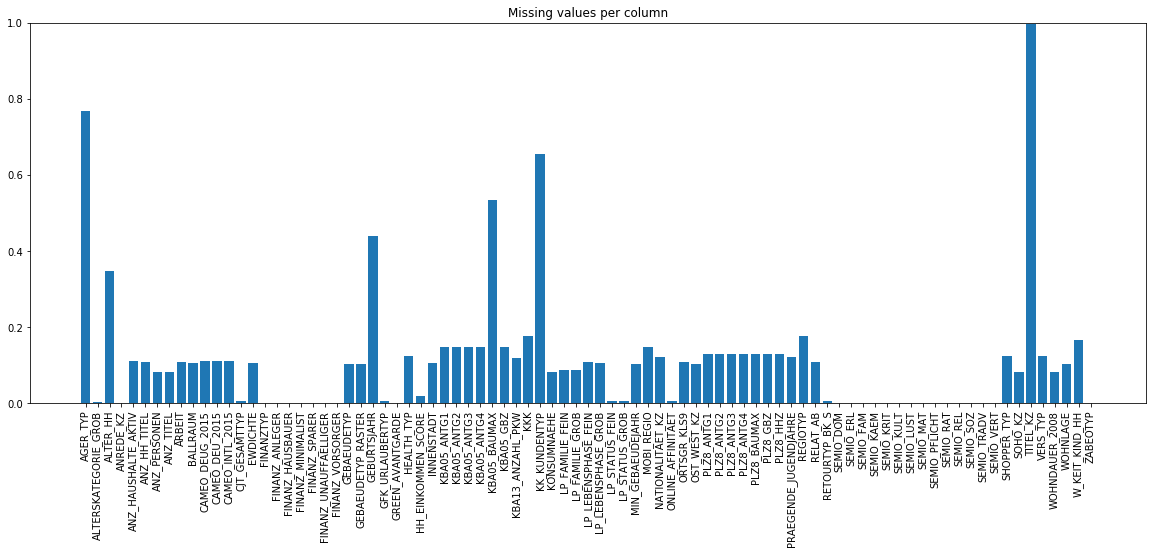

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def show_missing(df):
    plt.rcParams["figure.figsize"] = (20,7)
    bar_x = list(df.columns)
    bar_y = [df[col].isna().sum()/len(df) for col in bar_x]
    plt.bar(bar_x, bar_y)
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.title('Missing values per column')
    plt.show()
    
show_missing(azdias_with_missing)

In [8]:
# Investigate patterns in the amount of missing data in each column.
missing_proportions = {col: azdias_with_missing[col].isna().sum()/len(azdias_with_missing)\
                       for col in azdias_with_missing.columns}
missing_proportions_desc = {k: v for k, v in sorted(missing_proportions.items(), key= lambda x: -x[1])}
missing_proportions_asc = {k: v for k, v in sorted(missing_proportions.items(), key= lambda x: x[1])}

n_printed = 25

print('\nMost Missing:')
for i, col in enumerate(missing_proportions_desc):
    if i == n_printed:
        break
    print('{:>25}{:>25}'.format(col, missing_proportions_desc[col]))

    
print('\nMost Reliable:')
for i, col in enumerate(missing_proportions_asc):
    if i == n_printed:
        break
    print('{:>25}{:>25}'.format(col, missing_proportions_asc[col]))
    


Most Missing:
                 TITEL_KZ       0.9975763587258379
                 AGER_TYP       0.7695543529607134
             KK_KUNDENTYP       0.6559674873011295
             KBA05_BAUMAX       0.5346866826522265
              GEBURTSJAHR       0.4402028228688507
                 ALTER_HH      0.34813699407890975
                      KKK      0.17735668257368262
                 REGIOTYP      0.17735668257368262
           W_KEIT_KIND_HH      0.16605084485217472
              KBA05_ANTG1      0.14959701353536328
              KBA05_ANTG2      0.14959701353536328
              KBA05_ANTG3      0.14959701353536328
              KBA05_ANTG4      0.14959701353536328
                KBA05_GBZ      0.14959701353536328
               MOBI_REGIO      0.14959701353536328
               PLZ8_ANTG1      0.13073637178657146
               PLZ8_ANTG2      0.13073637178657146
               PLZ8_ANTG3      0.13073637178657146
               PLZ8_ANTG4      0.13073637178657146
              PL

In [9]:
# Collecting reliable columns
reliable_cols = {col: missing_proportions[col] for col in missing_proportions if missing_proportions[col] <= 0.001}
print(f'There are {len(reliable_cols)} reliable columns with zero or very few missing data.')

There are 24 reliable columns with zero or very few missing data.


In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
def remove_outlier_cols(df, outliers):
    return df.drop(outliers, axis=1)

outliers = [col for col in missing_proportions if missing_proportions[col] > 0.3]
print(outliers)
azdias_without_outliers = remove_outlier_cols(azdias_with_missing, outliers)
azdias_without_outliers.shape

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


(891221, 79)

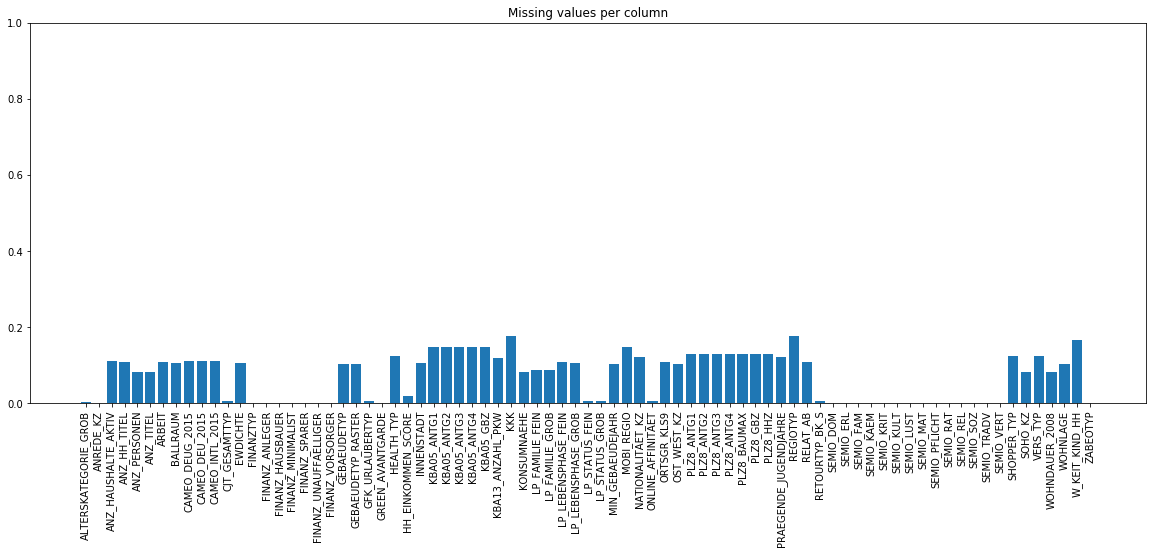

In [11]:
# Show missing data ratio after removing outliers, now no bars are too high!
show_missing(azdias_without_outliers)

#### Discussion 1.1.2: Assess Missing Data in Each Column

*(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)*

**ANSWER:** There're 24 strongly reliable columns with zero or very rare missing values. On the other hand there're six columns that could be considered as outliers since they've more than 30% missing data. Those six outliers are: *AGER_TYP*, *GEBURTSJAHR*, *TITEL_KZ*, *ALTER_HH*, *KK_KUNDENTYP* and *KBA05_BAUMAX*. Those outliers have been dropped.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

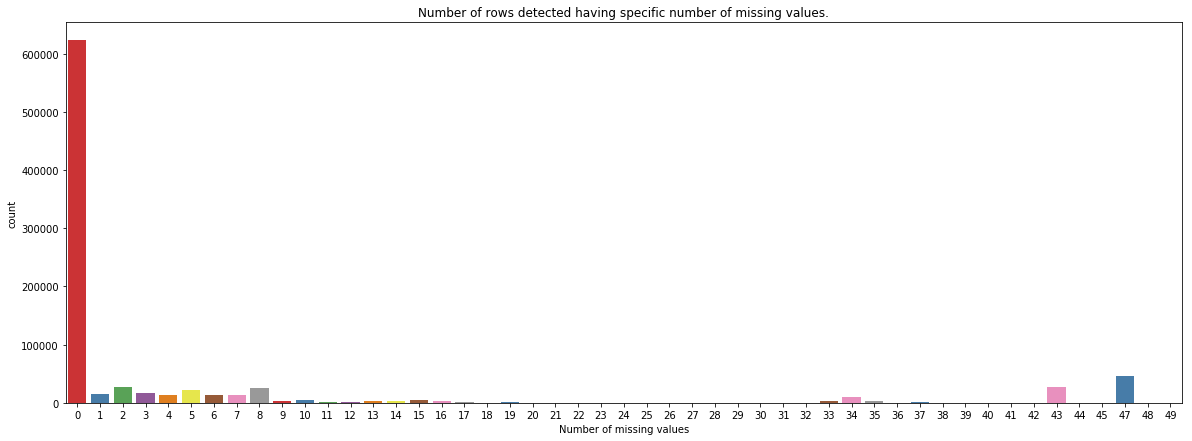

In [12]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias_without_outliers.isnull().sum(axis=1)
sns.countplot(missing_per_row, palette='Set1')
plt.title('Number of rows detected having specific number of missing values.')
plt.xlabel('Number of missing values')
plt.show()

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def split_messy_rows(df, threshold):
    df_clean = df[df.isnull().sum(axis=1) < threshold]
    df_messy = df[df.isnull().sum(axis=1) >= threshold]
    return df_clean, df_messy

threshold = 20
azdias_clean, azdias_messy = split_messy_rows(azdias_without_outliers, threshold)

if len(azdias_clean) + len(azdias_messy) == len(azdias_without_outliers):
    print('We are good.')
    
print(f'There are {len(azdias_clean)} rows under threshold, and {len(azdias_messy)} above or equal threshold.')

We are good.
There are 797077 rows under threshold, and 94144 above or equal threshold.


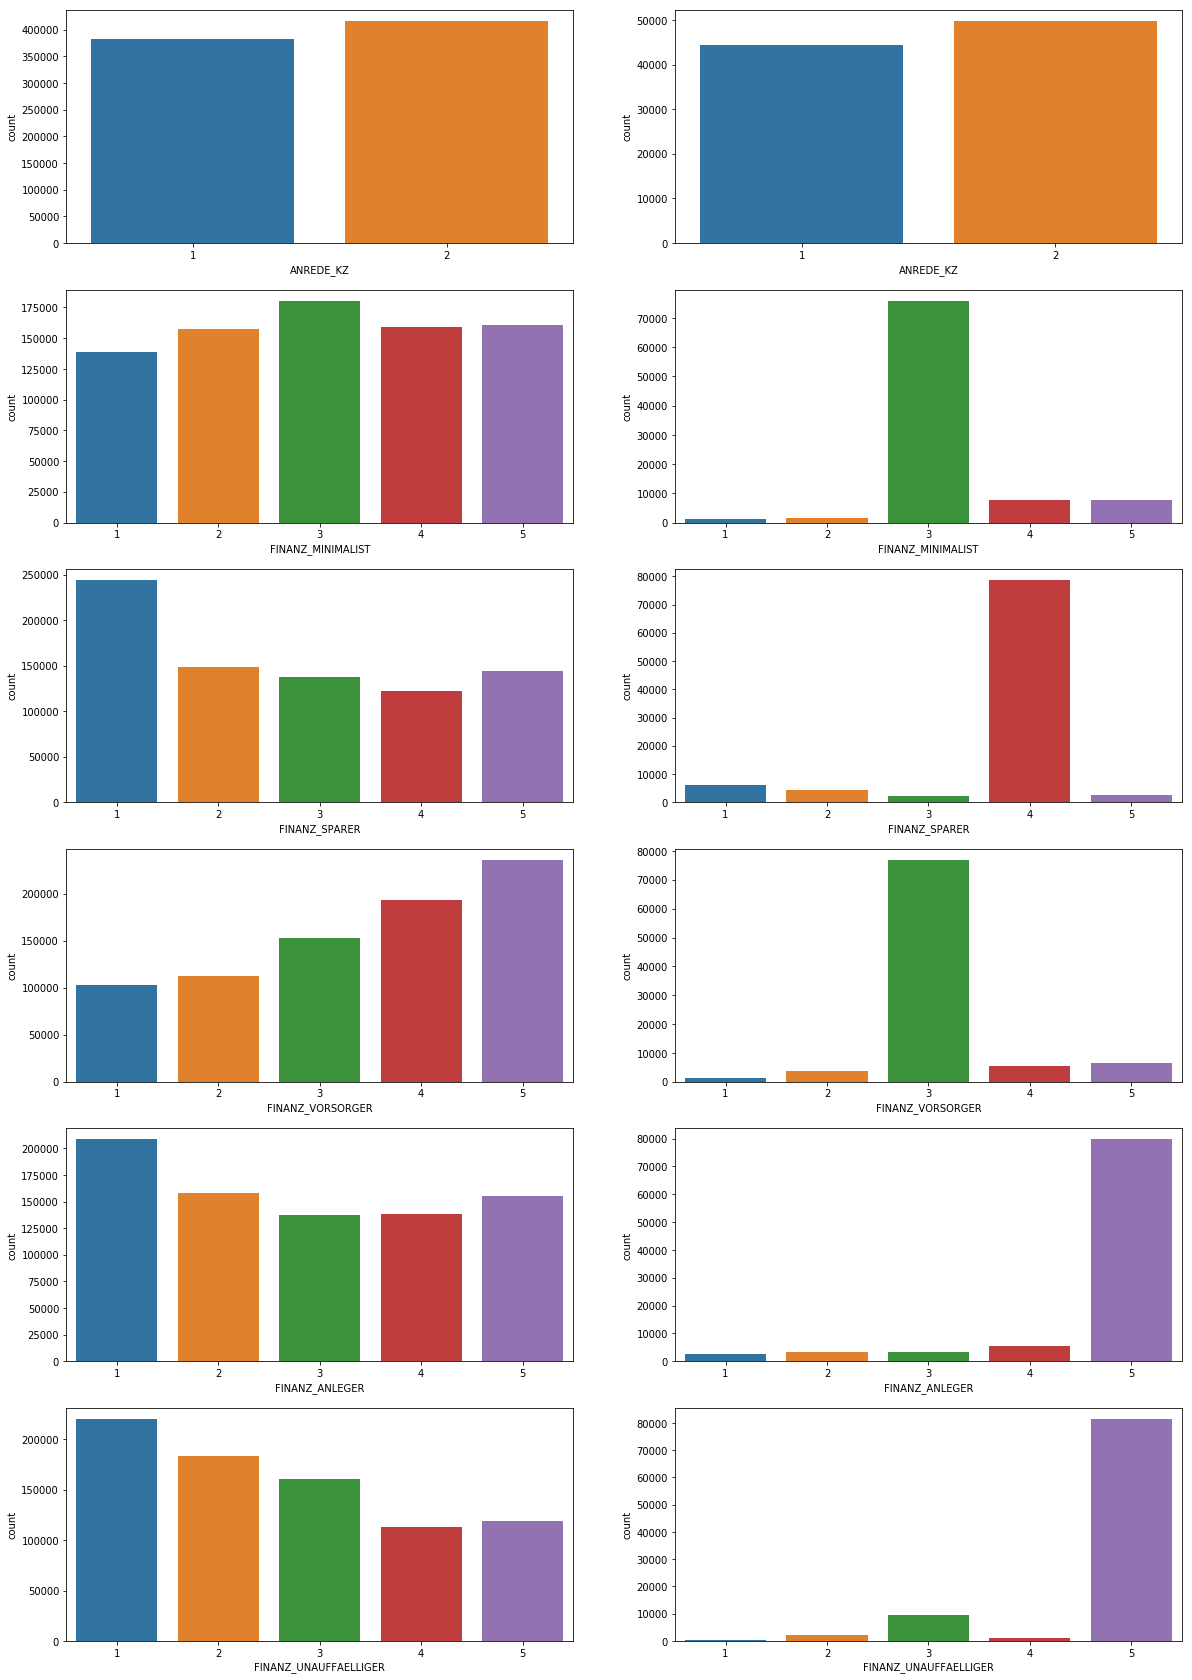

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_distributions(df_clean, df_messy, reliable_columns):
    plt.rcParams["figure.figsize"] = (20,30)
    n = len(reliable_columns)
    plt.subplots(n, 2)
    for i, col in enumerate(reliable_columns):
        plt.subplot(n, 2, 2*i + 1)
        sns.countplot(data=df_clean, x=col)
        plt.subplot(n, 2, 2*i + 2)
        sns.countplot(data=df_messy, x=col)
    plt.show()

reliable_columns = list(reliable_cols) # Because reliable_cols is a dictionary
compare_distributions(azdias_clean, azdias_messy, reliable_columns[:6])

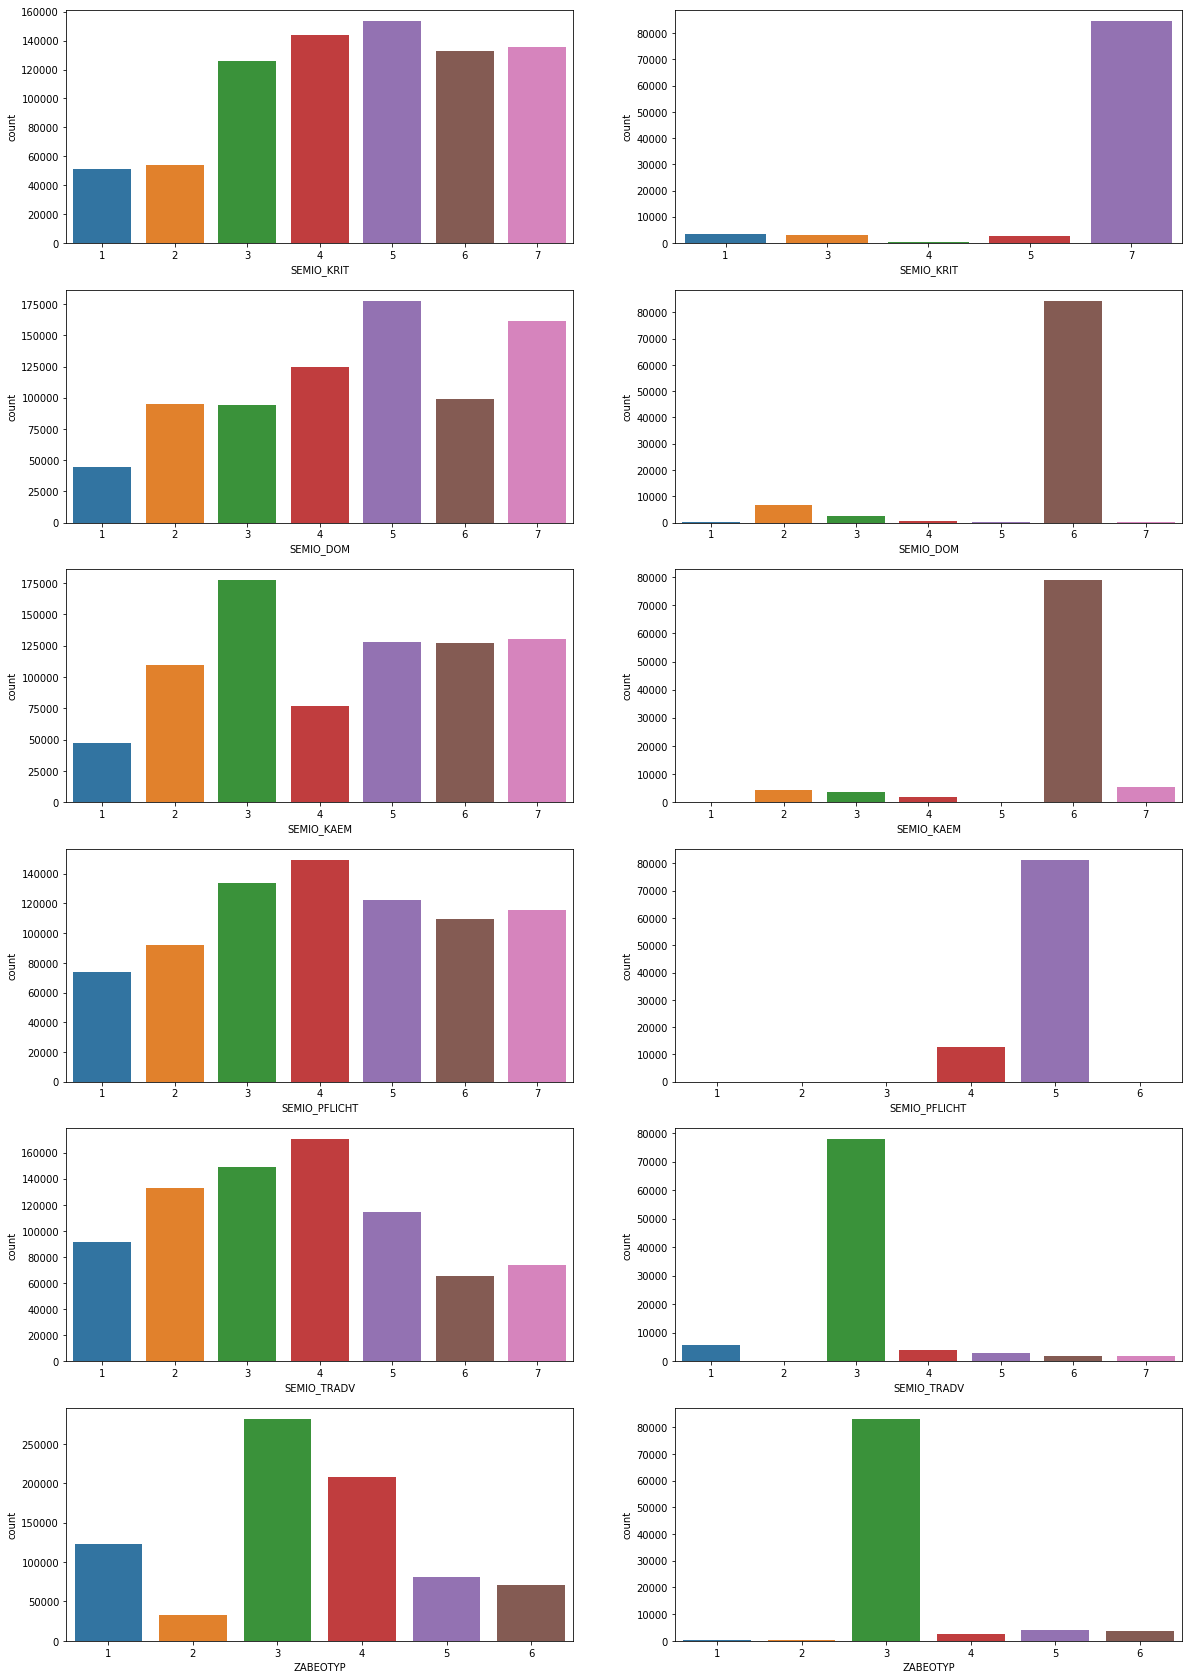

In [15]:
# Showing other six!

compare_distributions(azdias_clean, azdias_messy, reliable_columns[18:24])

#### Discussion 1.1.3: Assess Missing Data in Each Row

_(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)_

**ANSWER:** First, we can see in the graph of "Number of rows detected having spacific number of missing values" that there're almost no rows with ~20:30 missed values, rows either have far more or far less missed values, that hints that there're actually different distributons.

The graphs above largely certains that. Data with lots of missing values are indeed qualitatively different from data with few or no missing values. While *ARNEDE_KZ* is the only feature that has quite similar distributions, all of the other features massively differ. For example, *SEMIO PFLICHT* feature has 7 different values in clean data, while has almost only 2 values in the messy data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [17]:
# But what are the types of the outliers (which have been dropped)?
for i in feat_info.index:
    if feat_info.loc[i, 'attribute'] in outliers:
        print('{:>25}{:>25}'.format(feat_info.loc[i, 'attribute'], feat_info.loc[i, 'type']))

                 AGER_TYP              categorical
              GEBURTSJAHR                  numeric
                 TITEL_KZ              categorical
                 ALTER_HH                 interval
             KK_KUNDENTYP              categorical
             KBA05_BAUMAX                    mixed


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute']
categorical_features = list(categorical_features)
categorical_features = [c for c in categorical_features if c not in outliers]
print(len(categorical_features)) # 18 because there're 21 categorical features and 3 of them are outliers.

18


In [19]:
# Taking a look at the categorical features.
categorical_df = azdias_clean[categorical_features].copy()
categorical_df.head()

ANREDE_KZ  CJT_GESAMTTYP  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  \
1          2            5.0          1             10.0                 0   
2          2            3.0          1             10.0                 1   
3          2            2.0          6              1.0                 0   
4          1            5.0          5              5.0                 0   
5          2            2.0          2              1.0                 0   

   LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB  \
1              5.0              3.0             2.0             1.0   
2              1.0              1.0             3.0             2.0   
3              NaN              NaN             9.0             4.0   
4             10.0              5.0             3.0             2.0   
5              1.0              1.0             4.0             2.0   

   NATIONALITAET_KZ  SHOPPER_TYP  SOHO_KZ  VERS_TYP  ZABEOTYP  GEBAEUDETYP  \
1               1.0          3.0      1.0       2.0         5          8.0   
2               1.0          2.0      0.0       1.0         5          1.0   
3               1.0          1.0      0.0       1.0         3          1.0   
4               1.0          2.0      0.0       2.0         4          1.0   
5               1.0          0.0      0.0       2.0         4          1.0   

  OST_WEST_KZ CAMEO_DEUG_2015 CAMEO_DEU_2015  
1           W               8             8A  
2           W               4             4C  
3           W               2             2A  
4           W               6             6B  
5           W               8             8C

In [20]:
# Investigating categorical features: data types and number of different values.
n_categories = categorical_df.nunique()
categories_types = categorical_df.dtypes
categories_info = pd.concat([n_categories, categories_types], axis=1)
categories_info.rename(columns={0:'n_categories', 1:'dtype'}, inplace=True)
categories_info

n_categories    dtype
ANREDE_KZ                    2    int64
CJT_GESAMTTYP                6  float64
FINANZTYP                    6    int64
GFK_URLAUBERTYP             12  float64
GREEN_AVANTGARDE             2    int64
LP_FAMILIE_FEIN             11  float64
LP_FAMILIE_GROB              5  float64
LP_STATUS_FEIN              10  float64
LP_STATUS_GROB               5  float64
NATIONALITAET_KZ             3  float64
SHOPPER_TYP                  4  float64
SOHO_KZ                      2  float64
VERS_TYP                     2  float64
ZABEOTYP                     6    int64
GEBAEUDETYP                  7  float64
OST_WEST_KZ                  2   object
CAMEO_DEUG_2015              9   object
CAMEO_DEU_2015              44   object

In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.
# First, the binary non-numerical feature
def handle_bi_non(df, bi_non, verbose=1):
    df_copy = df.copy()
    for i, col in enumerate(bi_non):
        if verbose:
            print(f'{col} {i+1}/{len(bi_non)}')
            
        two_cats = df_copy[col].unique()
        if verbose:
            print(f'Before: {two_cats}')
            
        df_copy[col] = df_copy[col].apply(lambda x: 0 if x == two_cats[0] else 1)
        
        two_cats = df_copy[col].unique()
        if verbose:
            print(f'After: {two_cats}')
        
        return df_copy

bi_non = ['OST_WEST_KZ']
data_cat_eng = handle_bi_non(azdias_clean, bi_non)

OST_WEST_KZ 1/1
Before: ['W' 'O']
After: [0 1]


In [22]:
# Second, the multi-level categoricals
multilevel_info = categories_info[categories_info['n_categories'] > 2].copy()
multilevel_info.sort_values('n_categories', inplace=True)
display(multilevel_info)

n_categories    dtype
NATIONALITAET_KZ             3  float64
SHOPPER_TYP                  4  float64
LP_FAMILIE_GROB              5  float64
LP_STATUS_GROB               5  float64
CJT_GESAMTTYP                6  float64
FINANZTYP                    6    int64
ZABEOTYP                     6    int64
GEBAEUDETYP                  7  float64
CAMEO_DEUG_2015              9   object
LP_STATUS_FEIN              10  float64
LP_FAMILIE_FEIN             11  float64
GFK_URLAUBERTYP             12  float64
CAMEO_DEU_2015              44   object

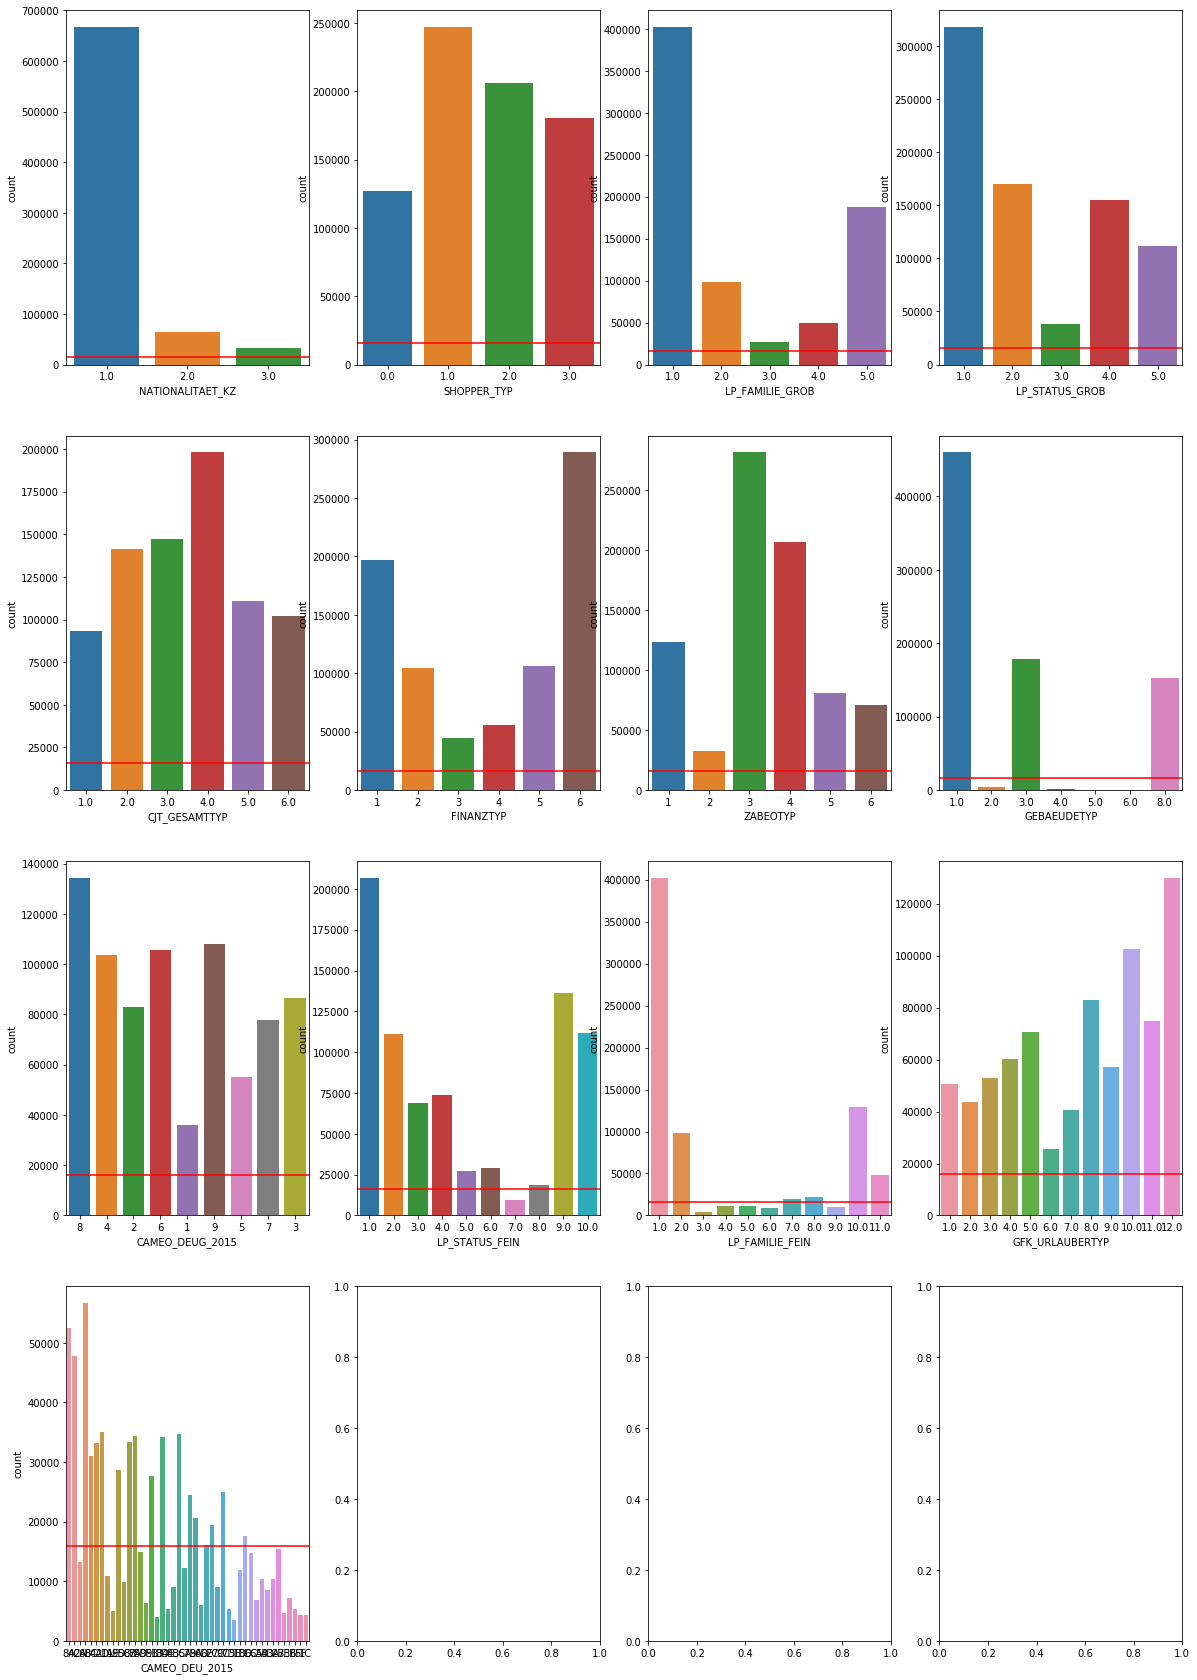

In [23]:
multilevel = list(multilevel_info.index)
def show_multilevel(df, multilevel, plot_nr, plot_nc):
    plt.subplots(plot_nr, plot_nc)
    for i, col in enumerate(multilevel):
        plt.subplot(plot_nr, plot_nc, i+1)
        sns.countplot(data=df, x=col)
        plt.axhline(y=int(len(df)*0.02), color='r')
            
    plt.show()
    
show_multilevel(data_cat_eng, multilevel, 4, 4)

In [24]:
# Handling other multilevel categoricals.
def handle_multilevel(df, to_binary, to_dummies, to_drop, threshold_to_bi):
    df_copy = df.copy()
    for col, th in zip(to_binary, threshold_to_bi):
        df_copy[col] = df_copy[col].apply(lambda x: 0 if x < th else 1)    
    return pd.get_dummies(df_copy, columns=to_dummies).drop(to_drop, axis=1)


to_binary = ['GEBAEUDETYP']
to_drop = ['LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015']
to_dummies = [col for col in multilevel if col not in to_binary+to_drop]
threshold_to_bi = [3]
data_after_dummies = handle_multilevel(data_cat_eng, to_binary, to_dummies, to_drop, threshold_to_bi)
data_after_dummies.shape  # (_, 123)

(797077, 123)

#### Discussion 1.2.1: Re-Encode Categorical Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*

**ANSWER:** As shown in the graph above, there're 13 multilevel features, three of them (*LP_STATUS_FEIN*, *LP_FAMILIE_FEIN* and *CAMEO_DEU_2015*) are detailed versions of other three (*LP_STATUS_GROB*, *LP_FAMILIE_GROB* and *CAMEO_DEUG_2015*). The problem with the detailed three is not just they would be too overwhelming in the ML processes, but most importantly their categories are not well-represented in the demographics data at all, It's easy to notice that by seeing many bars are under the horizontal red lines in the above graphs (horizontal red lines point to 2% of the demographics), that could lead to misguided results. So those three detailed features have been dropped, and the three summarized features have been kept after being converted to dummy variables.

Another case is the case of the *GEBAEUDETYP* feature, it has 8 different detailed classes while it just actually points to only two different classes (type of building: resedential or commercial), the over-detailed classes are not well-represented in the data, the clearest example is the class labeled by 5 which is marked by only ONE data sample in the whole dataset. This feature has been converted to a binary feature, depending on information provided in `Data_Dictionary.md`.

The other categorical features have been kept after being converted to dummy variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
'''
From the Data_Dictionary.md file:

-1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''
def mixed1(df):
    df_copy = df.copy()
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    decades = [None, 40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    df_copy['MOVEMENT'] = df_copy['PRAEGENDE_JUGENDJAHRE'].apply(\
                                            lambda x: x if np.isnan(x) else 1 if int(x) in mainstream else 0)
    df_copy['DECADES'] = df_copy['PRAEGENDE_JUGENDJAHRE'].apply(\
                                            lambda x: x if np.isnan(x) else decades[int(x)]//10 - 4)
    
    return df_copy.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    

data_1st_inv = mixed1(data_after_dummies)
data_1st_inv.shape # (_, 123 + 2 new features - 1 dropped features = 124)

(797077, 124)

In [26]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
'''
From the Data_Dictionary.md file:

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
'''
def mixed2(df):
    df_copy = df.copy()
    # here I'll use type(x) != str instead of isnan(x) because isnan() doesn't accept strings as input.
    df_copy['CAMEO_INTL_2015_dig1'] = df_copy['CAMEO_INTL_2015'].apply(\
                                                            lambda x: np.nan if type(x) != str else int(x)//10)
    df_copy['CAMEO_INTL_2015_dig2'] = df_copy['CAMEO_INTL_2015'].apply(\
                                                            lambda x: np.nan if type(x) != str else int(x)%10)
    return df_copy.drop('CAMEO_INTL_2015', axis=1)


data_2nd_inv = mixed2(data_1st_inv)
data_2nd_inv.shape # (_, 124 + 2 new features - 1 dropped feature = 125)

(797077, 125)

In [27]:
# Investigating other mixed features
# From out[18] there're 7 mixed features, 1 of them is an outlier and 2 of them have been handled already
# So there're 4 mixed features remaining.
handled = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
mixed_features = list(feat_info[feat_info['type'] == 'mixed']['attribute'])
mixed_features = [f for f in mixed_features if f not in handled+outliers]
mixed_features

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [28]:
# Investigating LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB
# Both of them describe life stage in fine and rough scale respectively
# But this information is included in other features already
def mixed3(df):
    return df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)


data_3rd_inv = mixed3(data_2nd_inv)
data_3rd_inv.shape # (_, 125 - 2 = 123)


(797077, 123)

In [29]:
# Investigating WOHNLAGE
display(data_3rd_inv['WOHNLAGE'].value_counts())

# WOHNLAGE is an ordinal feature from 1 to 6 that describes the quality of neighborhood
# When it's 7 or 8 it becomes a rural flag

def mixed4(df):
    is_rural = lambda x: 1 if x in [7, 8] else 0
    df_copy = df.copy()
    df_copy['WOHNLAGE_RURAL'] = df_copy['WOHNLAGE'].apply(lambda x: x if np.isnan(x) else is_rural(x))
    return df_copy.drop('WOHNLAGE', axis=1)

data_4th_inv = mixed4(data_3rd_inv)
data_4th_inv.shape # (_, 123 + 1 - 1 = 123)

3.0    249537
7.0    169238
4.0    135867
2.0    100303
5.0     74274
1.0     43876
8.0     17356
0.0      6626
Name: WOHNLAGE, dtype: int64

(797077, 123)

In [30]:
# Investigating PLZ8_BAUMAX
display(data_4th_inv['PLZ8_BAUMAX'].value_counts())

# PLZ8_BAUMAX is an ordinal feature from 1 to 4 that describes number of family homes around
# Only when it's 5 it becomes a business buildings flag

def mixed5(df):
    get_fhomes = lambda x: 1 if x == 5 else x
    is_business = lambda x: 1 if x == 5 else 0
    df_copy = df.copy()
    df_copy['PLZ8_FAMILY_HOMES'] = df_copy['PLZ8_BAUMAX'].apply(lambda x: x if np.isnan(x) else get_fhomes(x))
    df_copy['PLZ8_BUSINESS'] = df_copy['PLZ8_BAUMAX'].apply(lambda x: x if np.isnan(x) else is_business(x))
    return df_copy.drop('PLZ8_BAUMAX', axis=1)

data_5th_inv = mixed5(data_4th_inv)
data_5th_inv.shape # (_, 123 + 2 - 1 = 124)

1.0    499540
5.0     97333
2.0     70406
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX, dtype: int64

(797077, 124)

#### Discussion 1.2.2: Engineer Mixed-Type Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*

**ANSWER:** As seen before, there're 7 mixed-type features, two of them have been already handled and one of them has been dropped as an outlier, that makes only four mixed-type features remain, which are: *LP_LEBENSPHASE_FEIN*, *LP_LEBENSPHASE_GROB*, *WOHNLAGE* and *PLZ8_BAUMAX*.

The first two are rough and fine versions of the same data, which represnt information like family flag, single/not flag and income categories, but this information is already included in other features, so I dropped these two features. This is done in the function `mixed3()`.

The third feature is an ordinal variable that describes the neighborhood quality when it's between (and included) 1 and 6, but when it's 7 or 8 then it's a rural flag, while 0 means no score is calculated. I extracted a rural flag from this feature, but extracting quality score won't be very efficient, since labels 0, 7 and 8 don't provide any information about such score, that would make the quality score feature an outlier column with so many missing values. That ends up with this feature having only a rural flag. This is done in the function `mixed4()`  

The fourth feature is an interval variable that represents how many family homes are around, but only when it's 5 it becomes a flag of business building around. I extracted two engineered features as follows:

- *PLZ8_FAMILY_HOMES*: An interval feature takes value from 1 to 5. 1 means no, 1 or 2 family homes around and 5 means the most possible number of family homes in the area.
- *PLZ8_BUSINESS*: A binary categorical that determines if it's a mainly business buldings area or not.

This is done in the function `mixed5()`.





#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [31]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Nothing to do

In [32]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Nothing to do

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [34]:
def clean_data(df, feat_info, outliers, threshold, bi_non, to_dummies, to_drop, threshold_to_bi):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print('Converting all missed data to NaNs...')
    df_with_missing = to_nan(df, feat_info, verbose=0)
    
    
    # remove selected columns and rows, ...
    print('Removing messy columns and rows...')
    df_without_outliers = remove_outlier_cols(df_with_missing, outliers)
    df_clean, _ = split_messy_rows(df_without_outliers, threshold)
    print(f'Number of columns now is {df_clean.shape[1]}, should be 79')
    

    
    # select, re-encode, and engineer column values.
    print('Selecting, re-encoding and engineering...')
    data_cat_eng = handle_bi_non(df_clean, bi_non)
    data_after_dummies = handle_multilevel(data_cat_eng, to_binary, to_dummies, to_drop, threshold_to_bi)
    print(f'Number of columns now is {data_after_dummies.shape[1]}, should be 123')
    data_1st_inv = mixed1(data_after_dummies)
    print(f'Number of columns now is {data_1st_inv.shape[1]}, should be 124')
    data_2nd_inv = mixed2(data_1st_inv)
    print(f'Number of columns now is {data_2nd_inv.shape[1]}, should be 125')
    data_3rd_inv = mixed3(data_2nd_inv)
    print(f'Number of columns now is {data_3rd_inv.shape[1]}, should be 123')
    data_4th_inv = mixed4(data_3rd_inv)
    print(f'Number of columns now is {data_4th_inv.shape[1]}, should be 123')
    data_5th_inv = mixed5(data_4th_inv)
    print(f'Number of columns now is {data_5th_inv.shape[1]}, should be 124')

    
    # Return the cleaned dataframe.
    # Returning df_clean also because it's the version with the original columns
    # That will make using inverse_transform() methods unnecessary
    return data_5th_inv, df_clean


assert data_5th_inv.shape == clean_data(azdias, feat_info, outliers, threshold, bi_non,
                                  to_dummies, to_drop, threshold_to_bi)[0].shape

Converting all missed data to NaNs...
Removing messy columns and rows...
Number of columns now is 79, should be 79
Selecting, re-encoding and engineering...
OST_WEST_KZ 1/1
Before: ['W' 'O']
After: [0 1]
Number of columns now is 123, should be 123
Number of columns now is 124, should be 124
Number of columns now is 125, should be 125
Number of columns now is 123, should be 123
Number of columns now is 123, should be 123
Number of columns now is 124, should be 124


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [35]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
nan_info(data_5th_inv)

There are 790760 missing values. (0.8001%).
There are 173866 rows with missing values. (21.81%).


In [36]:
# Since missing data is less than 1%, a quick imputation might be fine!
from sklearn.preprocessing import Imputer

def do_impute(df, model=None):
    # If no model is passed as an argument, the function will create one
    imputer_model = model if model else Imputer()
    
    # If a trained model is passed as an argument then only transform() will be used, otherwise fit_transform()
    imputed_data = imputer_model.transform(df) if model else imputer_model.fit_transform(df)
    imputed_data = pd.DataFrame(imputed_data, columns = data_5th_inv.columns)
    
    # Ignore the first return value if a trained model has been passed already
    return imputer_model, imputed_data

imputer_model, imputed_data = do_impute(data_5th_inv)
nan_info(imputed_data)

There are 0 missing values. (0.0%).
There are 0 rows with missing values. (0.0%).


In [37]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

def do_scale(df, model=None):
    # If no model is passed as an argument, the function will create one
    scaler_model = model if model else StandardScaler()
    
    # If a trained model is passed as an argument then only transform() will be used, otherwise fit_transform()
    scaled_data = scaler_model.transform(df) if model else scaler_model.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data, columns = imputed_data.columns)
    
    # Ignore the first return value if a trained model has been passed already
    return scaler_model, scaled_data

scaler_model, scaled_data = do_scale(imputed_data)
scaled_data.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -1.765596   0.958121          -1.494463       1.538139   
1              0.201448   0.958121          -1.494463       0.864753   
2              1.184971   0.958121           0.683285      -0.482020   
3              0.201448  -1.043709           0.683285       0.191366   
4             -1.765596   0.958121          -0.042631      -1.155407   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -1.040664        1.466401               0.959974          1.338532   
1         -1.766903       -0.570914               0.245238          1.338532   
2          1.138052       -0.570914              -1.184235         -0.792444   
3          0.411813       -1.250019               0.245238         -0.792444   
4          1.138052       -0.570914              -0.469499          1.338532   

   GREEN_AVANTGARDE  HEALTH_TYP      ...        GFK_URLAUBERTYP_10.0  \
0         -0.530654    1.085338      ...                    2.599537   
1          1.884467    1.085338      ...                    2.599537   
2         -0.530654   -0.270203      ...                   -0.384684   
3         -0.530654    1.085338      ...                   -0.384684   
4         -0.530654    1.085338      ...                   -0.384684   

   GFK_URLAUBERTYP_11.0  GFK_URLAUBERTYP_12.0  MOVEMENT   DECADES  \
0             -0.322405             -0.441418  0.553082  1.165504   
1             -0.322405             -0.441418 -1.874665  1.165504   
2             -0.322405             -0.441418  0.553082 -0.231903   
3             -0.322405             -0.441418  0.553082 -0.231903   
4             -0.322405             -0.441418  0.553082 -1.629311   

   CAMEO_INTL_2015_dig1  CAMEO_INTL_2015_dig2  WOHNLAGE_RURAL  \
0              1.190696             -1.265981       -0.552856   
1             -0.865318              0.761849       -0.552856   
2             -1.550656             -0.590038        1.808789   
3              0.505358              0.085906       -0.552856   
4              1.190696              0.761849        1.808789   

   PLZ8_FAMILY_HOMES  PLZ8_BUSINESS  
0          -0.495438      -0.384507  
1          -0.495438      -0.384507  
2          -0.495438      -0.384507  
3           0.627079      -0.384507  
4          -0.495438      -0.384507  

[5 rows x 124 columns]

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

**ANSWER:** Since the missing values are less than 1% of the data, A complex approach would not be very necessary, so I chose a quick imputation before feature scaling. Maybe dropping rows with missing value was also a fine option but I prefered to have *imputer_model* that may be useful later.

I also used StandardScaler class to make every thing in the data frame with mean of zero and standard deviation of one.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
from time import time

def do_pca(df, n_components=120, model=None):
    # If no model is passed as an argument, the function will create one depending on n_components
    pca_model = model if model else PCA(n_components=n_components) 
    
    before = time()
    # If a trained model is passed as an argument, then only transform() will be used, otherwise fit_transform()
    data_after_pca = pca_model.transform(df) if model else pca_model.fit_transform(df)
    time_taken = time() - before
    print(f'Time taken: {int(time_taken//60)}:{int(time_taken%60)}')
    
    # Ignore the first return value if a trained model has been passed already
    return pca_model, data_after_pca

pca_model, data_after_pca = do_pca(scaled_data, n_components=80)

Time taken: 1:11


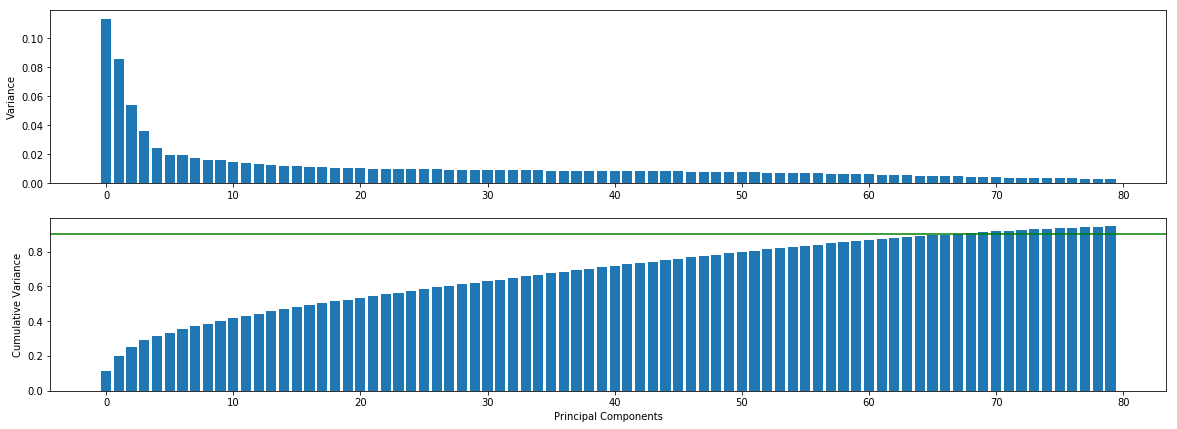

In [39]:
# Investigate the variance accounted for by each principal component.
def plot_pca(pca_model, good_ratio=0.9):
    variances = list(pca_model.explained_variance_ratio_)
    cumulative_variances = list(pca_model.explained_variance_ratio_.cumsum())
    comp_index = list(range(len(variances)))
    plt.rcParams["figure.figsize"] = (20,7)
    plt.subplots(2, 1)
    plt.subplot(2, 1, 1)
    plt.bar(comp_index, variances)
    plt.ylabel('Variance')
    plt.subplot(2, 1, 2)
    plt.bar(comp_index, cumulative_variances)
    plt.axhline(y=good_ratio, color='g')
    plt.xlabel('Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.show()
    
plot_pca(pca_model)

In [40]:
# Let's see when components pass 90%
cumulative_variances = list(pca_model.explained_variance_ratio_.cumsum())
n_components_less_90 = sum(list(map(lambda x: x<0.9, cumulative_variances)))
print(f'There are {n_components_less_90} compnents that their cumulative variance is less than 90%')
print(f'Component {n_components_less_90 + 1} has cumulative variance = {cumulative_variances[n_components_less_90]}.')

There are 67 compnents that their cumulative variance is less than 90%
Component 68 has cumulative variance = 0.9028737522733454.


In [41]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_model, data_after_pca = do_pca(scaled_data, 68)

Time taken: 1:5


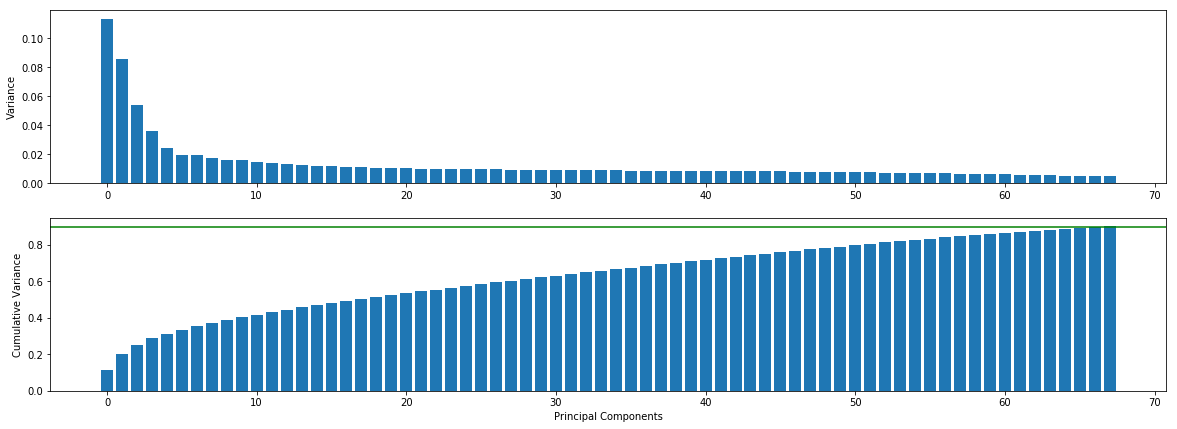

In [42]:
# Plotting the new PCA model.
plot_pca(pca_model)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**ANSWER:** Initially, I reduced the dimensions from 124 to 80, then plotting and investigating the principal components showed that only 68 components are enough to keep +90% of the variability. So the final choice is 68.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

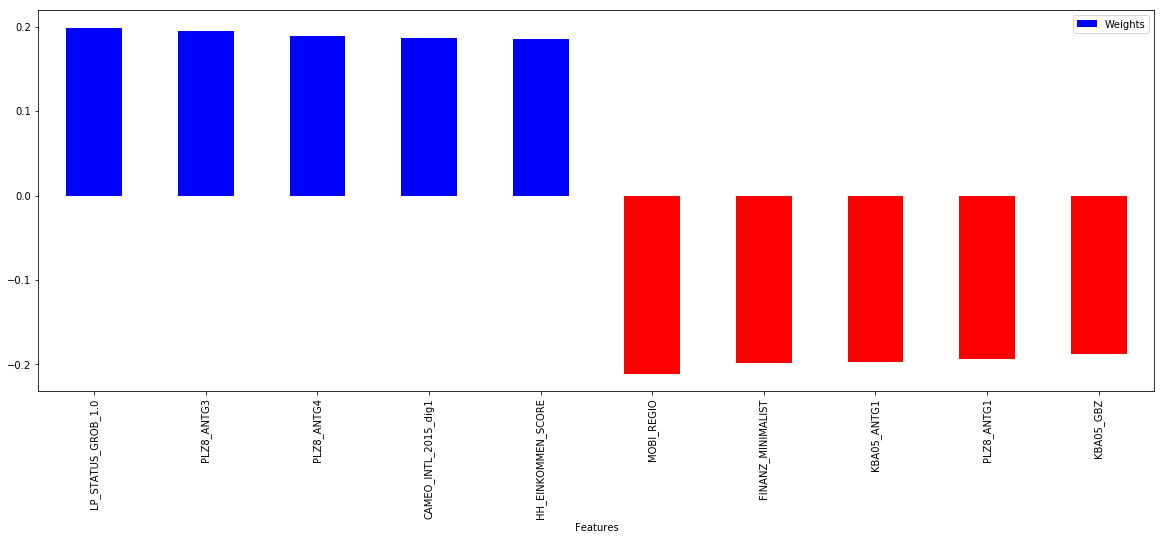

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(pca_model, feature_names, component_ind):
    component_weights = list(pca_model.components_[component_ind])
    weights_dict = dict(zip(feature_names, component_weights))
    weights_dict = dict(sorted(weights_dict.items(), key= lambda x: -abs(x[1])))
    return weights_dict


def print_dict(d, n):
    for i, k in enumerate(d):
        if i == n:
            return
        print('{:>25}{:>25}'.format(k, d[k]))
        

def show_weighted_features(d, n):
    df = pd.DataFrame(list(d.items()), columns=['Features', 'Weights'])
    df_pve = df[df['Weights'] >= 0]
    df_nve = df[df['Weights'] < 0]
    df_to_plot = pd.concat([df_pve[:n], df_nve[:n]], axis=0)
    df_to_plot.plot.bar(x='Features', y='Weights', color=['blue']*n+['red']*n)
    plt.show()
    

feature_names = list(scaled_data.columns)
first_component = map_weights(pca_model, feature_names, 0)
show_weighted_features(first_component, 5)
# print_dict(first_component, 20)

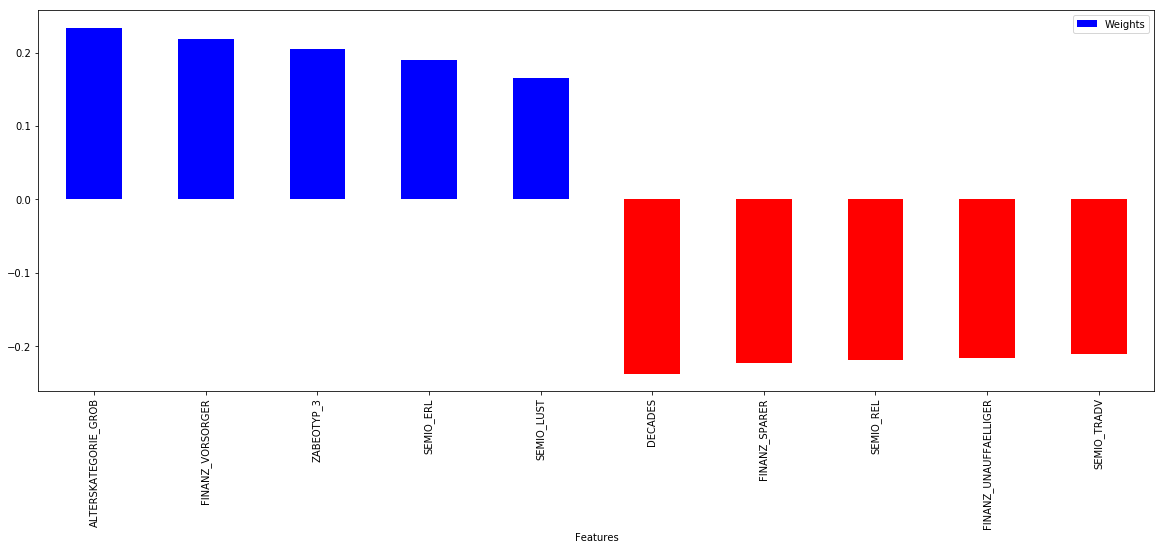

In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_component = map_weights(pca_model, feature_names, 1)
show_weighted_features(second_component, 5)

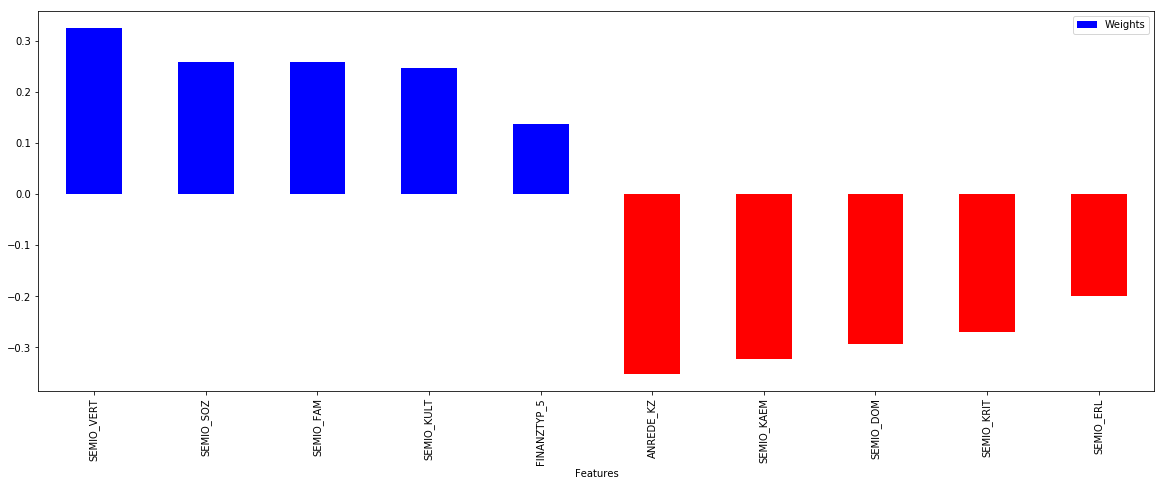

In [62]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_component = map_weights(pca_model, feature_names, 2)
show_weighted_features(third_component, 5)



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**ANSWER:** Yes, we can interpret positive and negative values from them in a meaningful way. For example, in the second component the greatest weights are given to *DECADES* and *ALTERSKATEGORIE_GROB* but in inverted signs. The first feature points to the decade of the dominent movement of person's generation (0 means the decade of 1940s and so on to 6 which means 1990s) and the second features is the estimated age feature, the inverse relation between the two features is clear.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
def do_kmeans(data, min_v, max_v, step):
    scores = []
    kmeans_models = []
    for i, n_clusters in enumerate(range(min_v, max_v+1, step)):
        print(f'{i+1} ....')
        
        # run k-means clustering on the data and...
        kmeans_models.append(KMeans(n_clusters=n_clusters))
        before = time()
        kmeans_models[i].fit(data_after_pca)
        time_taken = time() - before
        mins = int(time_taken//60)
        secs = int(time_taken%60)

        # compute the average within-cluster distances.
        scores.append(-kmeans_models[i].score(data))
        print(f'Time taken: {mins}:{secs}') 
        print(f'Running {n_clusters} clusters gives score of {scores[i]}\n')
    
    # Returning models & scores
    return kmeans_models, scores

global_before = time()
kmeans_models, scores = do_kmeans(data_after_pca, 8, 28, 4)
global_time_taken = time() - global_before
mins = int(global_time_taken//60)
secs = int(global_time_taken%60)
print(f'The whole process took {mins}:{secs}.')

1 ....
Time taken: 2:35
Running 8 clusters gives score of 68162819.50570539

2 ....
Time taken: 4:2
Running 12 clusters gives score of 65515497.711156145

3 ....
Time taken: 7:53
Running 16 clusters gives score of 63485604.54956634

4 ....
Time taken: 10:45
Running 20 clusters gives score of 62135180.90954036

5 ....
Time taken: 12:3
Running 24 clusters gives score of 61032147.553655654

6 ....
Time taken: 13:26
Running 28 clusters gives score of 60026319.02351163

The whole process took 50:50.


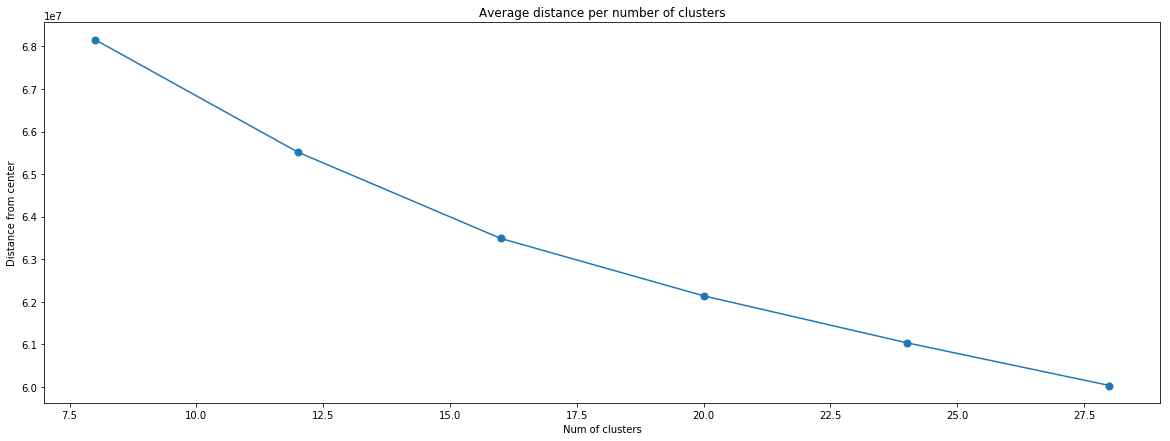

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def plot_kmeans(clusters, scores):
    plt.plot(clusters, scores, marker='.', markersize=14)
    plt.xlabel('Num of clusters')
    plt.ylabel('Distance from center')
    plt.title('Average distance per number of clusters')
    plt.show()

plot_kmeans(list(range(8,29,4)), scores)

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_model = kmeans_models[2] # Choosing 16 clusters which is the third model
labels = kmeans_model.predict(data_after_pca)

In [66]:
# Let's get back to our pandas dataframe
data_with_labels = azdias_clean.copy()
data_with_labels['CLUSTER'] = list(labels)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**ANSWER:** Trying several options between 10 and 30 clusters it seems that choosing 16 clusters is a fine option by the elbow method.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [67]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [68]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_after_clean, customers_original = clean_data(customers, feat_info, outliers,
                                                       threshold, bi_non, to_dummies, to_drop, threshold_to_bi)

Converting all missed data to NaNs...
Removing messy columns and rows...
Number of columns now is 79, should be 79
Selecting, re-encoding and engineering...
OST_WEST_KZ 1/1
Before: ['W' 'O']
After: [0 1]
Number of columns now is 123, should be 123
Number of columns now is 124, should be 124
Number of columns now is 125, should be 125
Number of columns now is 123, should be 123
Number of columns now is 123, should be 123
Number of columns now is 124, should be 124


In [69]:
# Investigating missing values in customers data
nan_info(customers_after_clean)

There are 107491 missing values. (0.6122%).
There are 25947 rows with missing values. (18.33%).


In [70]:
# Applying imputing
_, imputed_customers = do_impute(customers_after_clean, model=imputer_model)

In [71]:
# Applying feature scaling
_, scaled_customers = do_scale(imputed_customers, model=scaler_model)

In [72]:
# Applying PCA
_, customers_after_pca = do_pca(scaled_customers, model=pca_model)
customers_after_pca.shape

Time taken: 0:0


(141590, 68)

In [73]:
# Applying clustering
customers_labels = kmeans_model.predict(customers_after_pca)
customers_with_labels = customers_original.copy()
customers_with_labels['CLUSTER'] = list(customers_labels)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

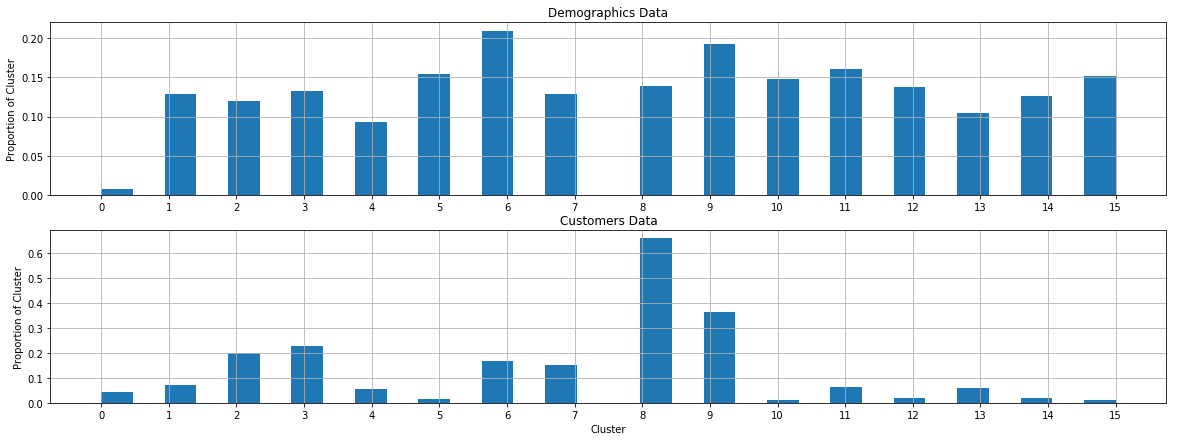

In [87]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def show_clusters(df1, df2):
    plt.subplots(2, 1)
    plt.subplot(2, 1, 1)
    # sns.countplot(data=df1, x='CLUSTER')
    df1['CLUSTER'].hist(density=1, bins=32)
    plt.xticks(list(range(16)))
    plt.ylabel('Proportion of Cluster')
    plt.title('Demographics Data')
    plt.subplot(2, 1, 2)
    # sns.countplot(data=df2, x='CLUSTER')
    df2['CLUSTER'].hist(density=1, bins=32)
    plt.xticks(list(range(16)))
    plt.xlabel('Cluster')
    plt.ylabel('Proportion of Cluster')
    plt.title('Customers Data')
    plt.show()
    
show_clusters(data_with_labels, customers_with_labels)

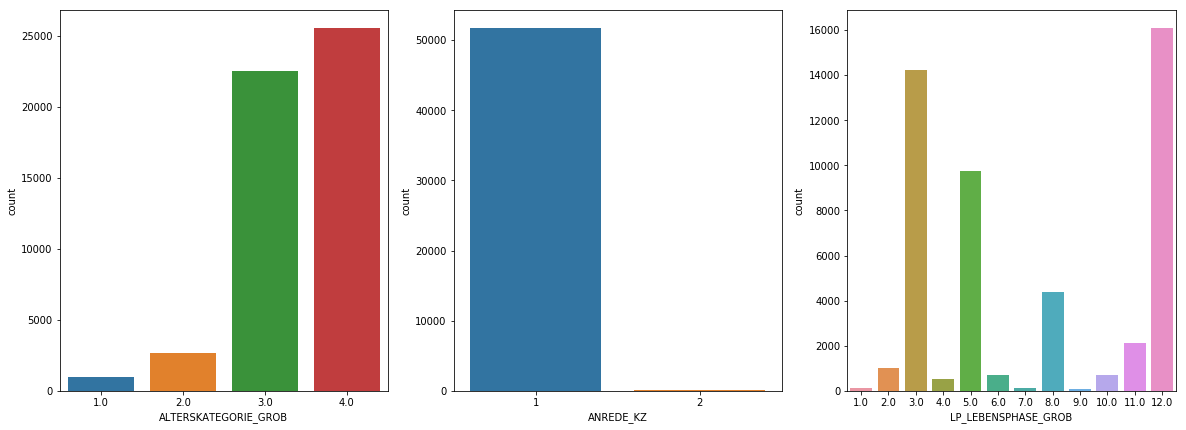

In [76]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

def show_cluster(df, cluster, chosen_features, plot_nr, plot_nc):
    THIS_CLUSTER = df[df['CLUSTER'] == cluster] 
    plt.subplots(plot_nr, plot_nc)
    for i, col in enumerate(chosen_features):
        plt.subplot(plot_nr, plot_nc, i+1)
        sns.countplot(data=THIS_CLUSTER, x=col)
    plt.show


chosen_features = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'LP_LEBENSPHASE_GROB']
show_cluster(data_with_labels, 8, chosen_features, 1, 3)

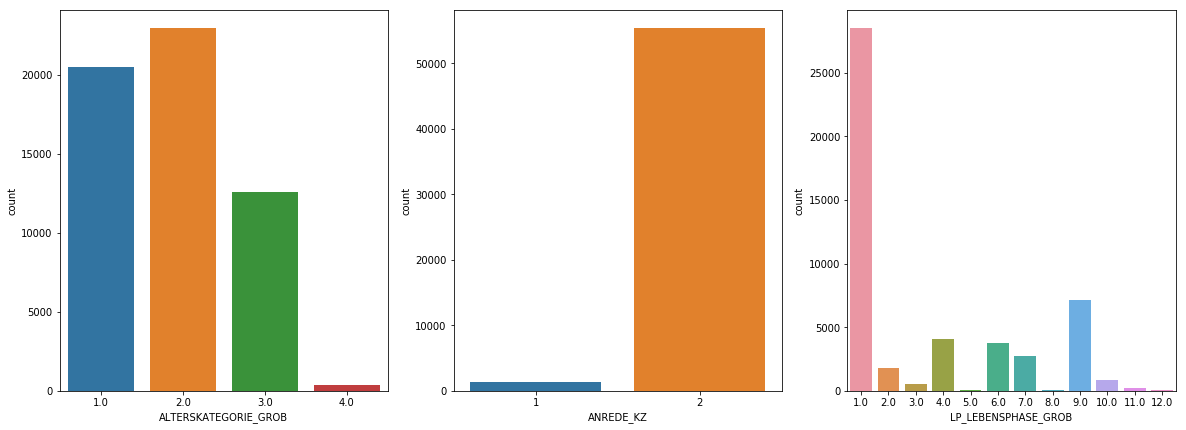

In [89]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
show_cluster(data_with_labels, 15, chosen_features, 1, 3)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**ANSWER**: In the overrepresented cluster we can find the most majority are males of high ages with high incomes. On the other side, taking a look at the underrepresented cluster, we can see the quite opposite, majority of females with young ages and less incomes. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.